In [ ]:
import re
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import string
import keras
import nltk
import gensim
import spacy
from nltk.corpus import wordnet
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
review = pd.read_csv('drive/MyDrive/data/employee_reviews_with_split.csv', encoding='latin')
review = review.sample(n=20000, random_state=426)

In [ ]:
review.reset_index(drop=True,inplace=True)
review_df = review[['review_all'] + ['overall_ratings'] + ['split']]
review_df.head()

,review_all,overall_ratings,split
0,Fun and extremely beneficial benefits. Not all...,3.0,val
1,"Get lots of responsibility, freedom to pursue ...",4.0,test
2,"People are great, very focus Narrower scope of...",5.0,train
3,employee caring and progressive culture. good ...,5.0,train
4,Opportunity to make worldwide impact Great peo...,4.0,train


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

import nltk
nltk.download('punkt')

review_df['review_all'] = review_df['review_all'].str.replace('[{}]'.format(string.punctuation), '')  
review_df['review_all'] = review_df['review_all'].str.replace(r'\s+', ' ') 
review_df['review_all'] = review_df['review_all'].str.replace(r'[^a-zA-Z0-9\s]', '')  

review_df['review_all'] = review_df['review_all'].apply(lambda x: x.lower())
stop_words = set(stopwords.words('english'))  
review_df['review_all'] = review_df['review_all'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))
lemmatizer = WordNetLemmatizer()
review_df['review_all'] = review_df['review_all'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))
stemmer = PorterStemmer()
review_df['review_all'] = review_df['review_all'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
review_df.head()

,review_all,overall_ratings,split
0,fun extrem benefici benefit allow buy stuff sa...,3.0,val
1,get lot respons freedom pursu want high impact...,4.0,test
2,peopl great focu narrow scope work other,5.0,train
3,employe care progress cultur good valu defens ...,5.0,train
4,opportun make worldwid impact great peopl work...,4.0,train


In [ ]:
# new time start form here
review_df.to_csv('drive/MyDrive/data/review_processed_split.csv', index=False)

##  next time start form here

In [ ]:
# stopwords, bigrams, trigrams and lemmatization functions
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')


def removeStopwords(texts):
    #custom_stopwords = set(['also', 'mr', 'one'])
    stop_words = set(stopwords.words('english'))  
    #stop_words.update(custom_stopwords)
    new_words = []
    for word in texts:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for s in texts:
        doc = nlp(" ".join(s)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
review_df = pd.read_csv('drive/MyDrive/data/modeldata_split.csv', encoding='latin')
reviewData = review_df['review'].values.tolist()

def newWords(sentence):
    for sentence in sentence:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # removing the punctuations

new_words = list(newWords(reviewData))

print(new_words[:1])

[['amazing', 'training']]


In [ ]:
# ngram models - bigram and trigram
bigram = gensim.models.Phrases(new_words, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[new_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# display a trigram
print(trigram_mod[bigram_mod[new_words[0]]])

['fun', 'extrem', 'benefici', 'benefit', 'allow', 'buy', 'stuff', 'samsung', 'get', 'work']


In [ ]:

# Stop words are removed
noStopWords = removeStopwords(new_words)

# Bigrams
new_words_bigrams = bigrams(noStopWords)

# spacy 'en' model with tagger component 

nlp = spacy.load("en_core_web_sm")

# lemmatization takes too much time
lemmatized_data = lemmatization(new_words_bigrams)

print(new_words_bigrams[:1])


KeyboardInterrupt: ignored

In [ ]:
'''
review_df = []
for i in range(len(lemmatized_data)):
    review_df.append(" ".join(lemmatized_data[i]))
review_df = pd.Series(review_df)
'''

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
numFeatures = 20000
tf_vectorizer = TfidfVectorizer(max_df=0.95,max_features=numFeatures)
tf = tf_vectorizer.fit_transform(review_df)
tf_feature_names = tf_vectorizer.get_feature_names_out()

In [ ]:
review_df.head()

,rating,review,split
0,2,amazing training,train
1,1,place social poeple aspire become robot correc...,train
2,1,250 million cash reserve cannot pay living wage,train
3,1,account manager,train
4,2,great retail job,train


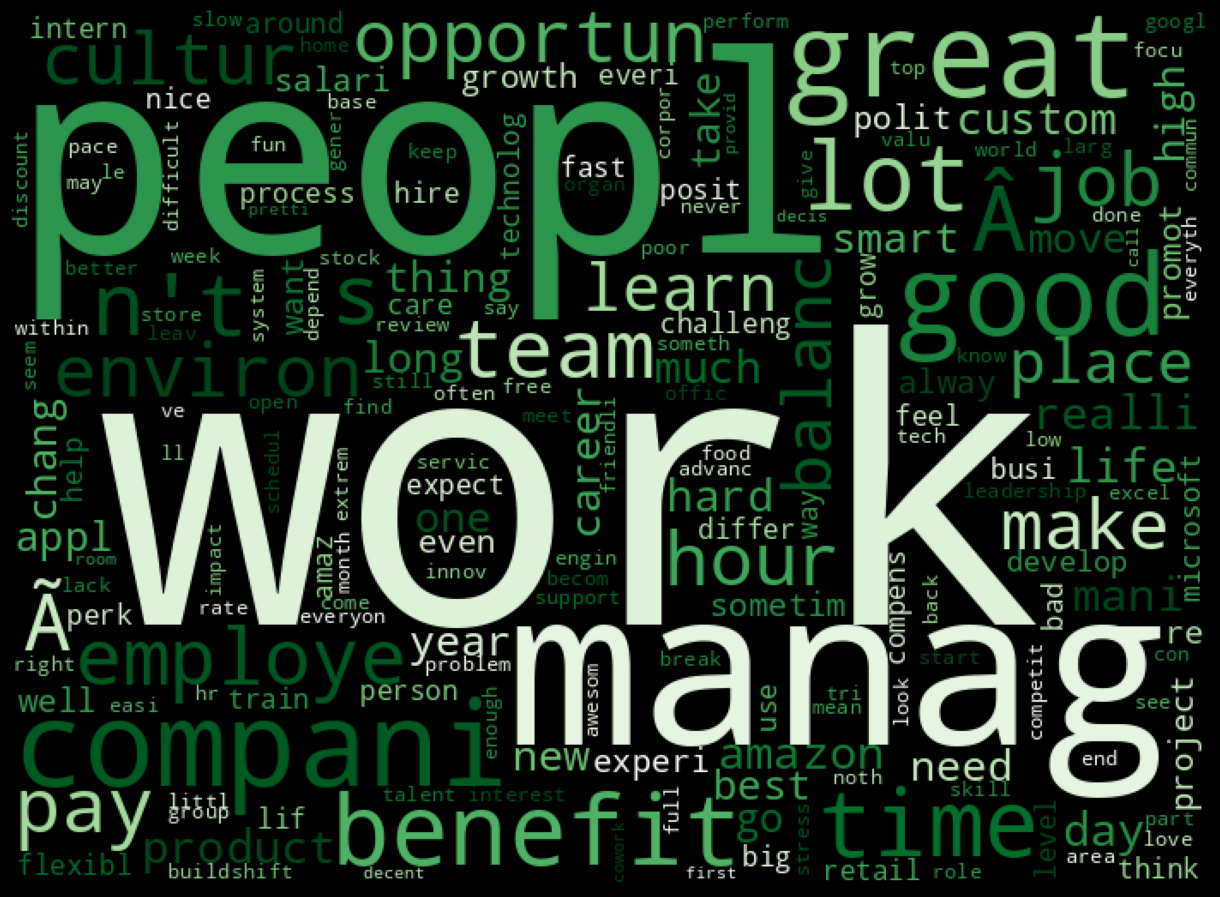

In [ ]:
from wordcloud import WordCloud
t = [x for x in review_df['review_all']]
w = ''.join(list(map(str,t)))
tweets_wc = WordCloud(width=700,height=512,collocations=False,colormap="Greens").generate(w)
plt.figure(figsize=(12, 10),facecolor='k')
plt.imshow(tweets_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

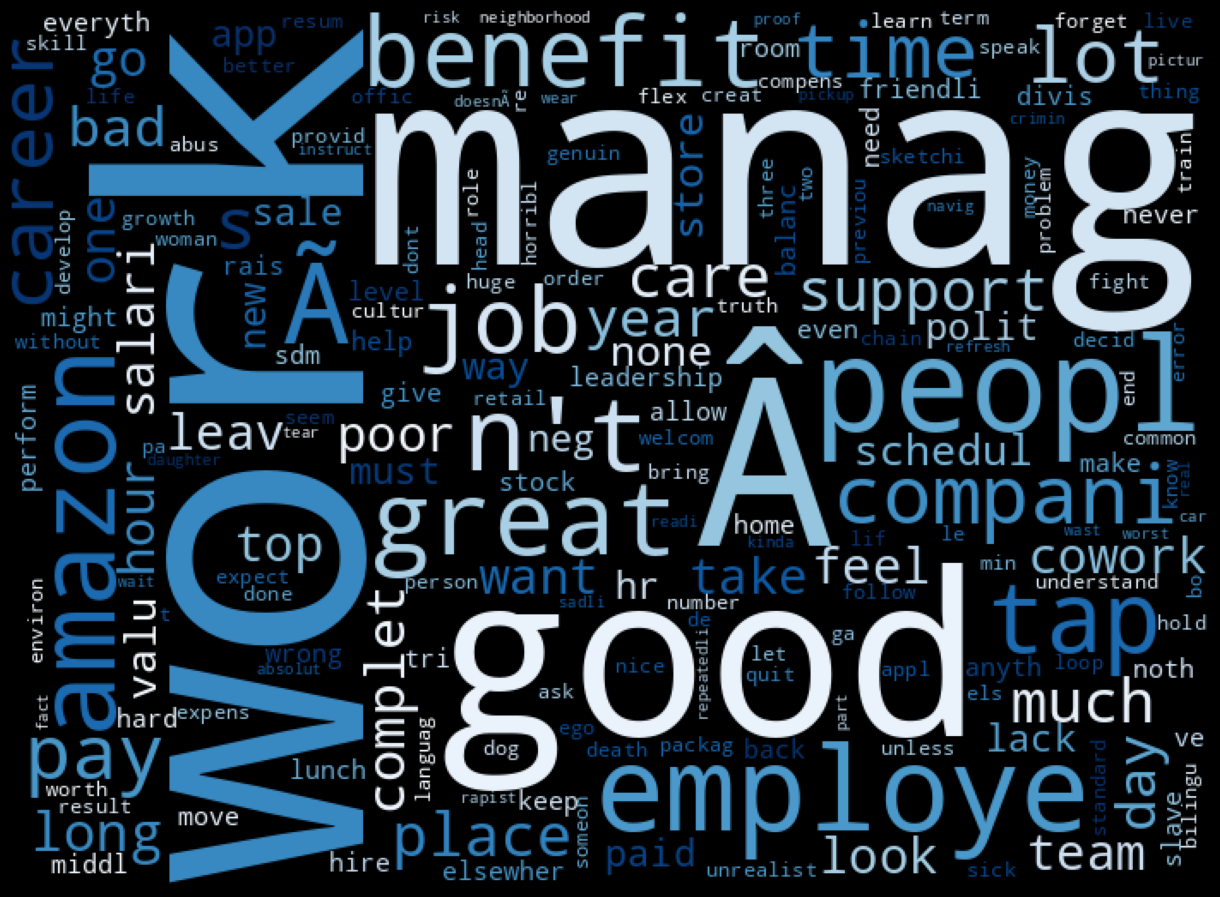

In [ ]:
t=[]
a=[]
from wordcloud import WordCloud
for i in range(30):
  t=review_df[review_df['overall_ratings']==1].iloc[i][0]
  a.insert(i,t)
w = ''.join(list(map(str,a)))
wc = WordCloud(width=700,height=512,collocations=False,colormap="Blues").generate(w)
plt.figure(figsize=(12, 10),facecolor='k')
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

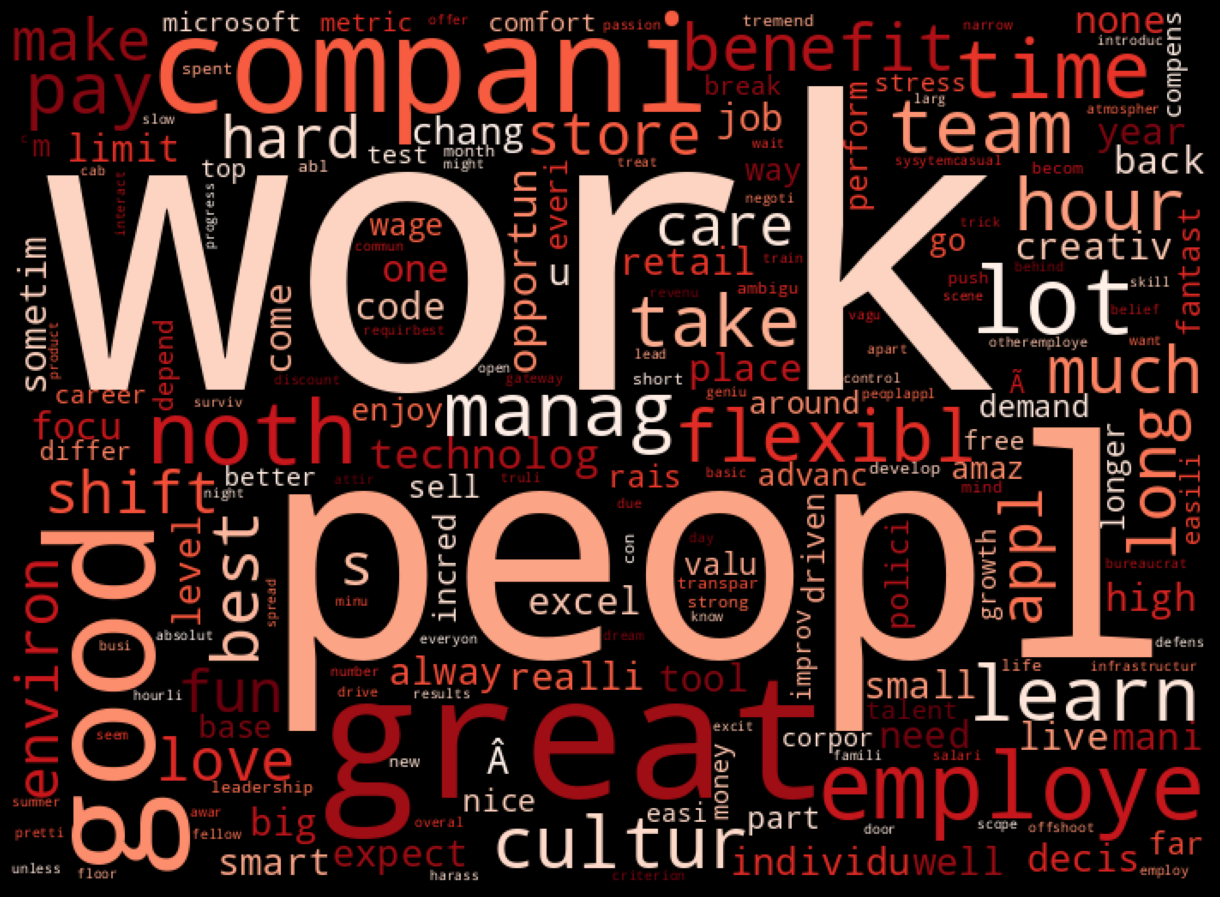

In [ ]:
t=[]
a=[]
from wordcloud import WordCloud
for i in range(30):
  t=review_df[review_df['overall_ratings']==5].iloc[i][0]
  a.insert(i,t)
w = ''.join(list(map(str,a)))
wc = WordCloud(width=700,height=512,collocations=False,colormap="Reds").generate(w)
plt.figure(figsize=(12, 10),facecolor='k')
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
#review_data = review_df['review_all'].values.tolist()
#review_data = [w.lower() for w in data]
allReviews = np.array(reviewData)
ratings = np.array(review_df['rating'])

In [ ]:
!pip install keras.preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.9 MB/s eta 0:00:00


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
maxWords = 30000
maxLength = 500

tokenizer = Tokenizer(num_words=maxWords)
tokenizer.fit_on_texts(allReviews)
sequences = tokenizer.texts_to_sequences(allReviews)
allReviews = pad_sequences(sequences, maxlen=maxLength)
print(allReviews)

[[   0    0    0 ...    0   29  208]
 [   0    0    0 ...  475 1950    5]
 [   0    0    0 ...   34  530  393]
 ...
 [   0    0    0 ...  210  447  161]
 [   0    0    0 ...    0    0  134]
 [   0    0    0 ...    0   60  222]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(allReviews,ratings,test_size=0.3, random_state=0)
print(len(X_train),len(X_test),len(y_train),len(y_test))

7411 3177 7411 3177


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(allReviews,ratings,test_size=0.3, random_state=0)

 Basic RNN with single LSTM layer

In [ ]:
#pip install tensorflow

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(maxWords, 30))
model1.add(layers.LSTM(50,dropout=0.2))
model1.add(layers.Dense(1,activation='sigmoid'))

model1.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

history = model1.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test))

Epoch 1/10


ValueError: ignored

In [ ]:
model2 = Sequential()
model2.add(layers.Embedding(maxWords, 40))
model2.add(layers.LSTM(40,dropout=0.5,return_sequences=True))
model2.add(layers.LSTM(40,dropout=0.5))
model2.add(layers.Dense(1,activation='sigmoid'))

model2.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

history = model2.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test))

Epoch 1/5
232/232 [==============================] - 170s 711ms/step - loss: -5.5610 - accuracy: 0.5010 - val_loss: -8.2136 - val_accuracy: 0.4976
Epoch 2/5
232/232 [==============================] - 163s 705ms/step - loss: -10.4740 - accuracy: 0.5010 - val_loss: -12.9306 - val_accuracy: 0.4976
Epoch 3/5
232/232 [==============================] - 162s 698ms/step - loss: -15.1481 - accuracy: 0.5010 - val_loss: -17.6119 - val_accuracy: 0.4976
Epoch 4/5
232/232 [==============================] - 165s 713ms/step - loss: -19.8248 - accuracy: 0.5010 - val_loss: -22.3271 - val_accuracy: 0.4976
Epoch 5/5
232/232 [==============================] - 162s 699ms/step - loss: -24.5022 - accuracy: 0.5010 - val_loss: -27.0304 - val_accuracy: 0.4976


In [ ]:
model3 = Sequential()
model3.add(layers.Embedding(maxWords, 40))
model3.add(layers.Bidirectional(layers.LSTM(40,dropout=0.5)))
model3.add(layers.Dense(1,activation='sigmoid'))

model3.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

history = model3.fit(X_train, y_train, epochs=8,validation_data=(X_test, y_test))

Epoch 1/8
232/232 [==============================] - 159s 658ms/step - loss: -9.1283 - accuracy: 0.5006 - val_loss: -14.5826 - val_accuracy: 0.4976
Epoch 2/8
232/232 [==============================] - 139s 600ms/step - loss: -19.0678 - accuracy: 0.5010 - val_loss: -23.8922 - val_accuracy: 0.4976
Epoch 3/8
232/232 [==============================] - 150s 648ms/step - loss: -28.3540 - accuracy: 0.5010 - val_loss: -33.1846 - val_accuracy: 0.4976
Epoch 4/8
232/232 [==============================] - 142s 611ms/step - loss: -37.5706 - accuracy: 0.5010 - val_loss: -42.5321 - val_accuracy: 0.4976
Epoch 5/8
232/232 [==============================] - 164s 708ms/step - loss: -46.7905 - accuracy: 0.5010 - val_loss: -51.7956 - val_accuracy: 0.4976
Epoch 6/8
232/232 [==============================] - 140s 605ms/step - loss: -56.0227 - accuracy: 0.5010 - val_loss: -61.1018 - val_accuracy: 0.4976
Epoch 7/8
232/232 [==============================] - 142s 613ms/step - loss: -65.3529 - accuracy: 0.5010 - 

In [ ]:
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
model4 = Sequential()
model4.add(layers.Embedding(maxWords, 40))
model4.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Dropout(0.2))

model4.add(LSTM(300))
model4.add(Dropout(0.2))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

history = model4.fit(X_train, y_train, epochs=7,validation_data=(X_test, y_test))

Epoch 1/7
232/232 [==============================] - 286s 1s/step - loss: -27.8769 - accuracy: 0.4993 - val_loss: -45.5554 - val_accuracy: 0.4976
Epoch 2/7
232/232 [==============================] - 286s 1s/step - loss: -62.5217 - accuracy: 0.5010 - val_loss: -79.8518 - val_accuracy: 0.4976
Epoch 3/7
232/232 [==============================] - 285s 1s/step - loss: -96.2856 - accuracy: 0.5010 - val_loss: -114.1132 - val_accuracy: 0.4976
Epoch 4/7
232/232 [==============================] - 281s 1s/step - loss: -130.0002 - accuracy: 0.5010 - val_loss: -148.2704 - val_accuracy: 0.4976
Epoch 5/7
232/232 [==============================] - 281s 1s/step - loss: -164.2631 - accuracy: 0.5010 - val_loss: -182.6092 - val_accuracy: 0.4976
Epoch 6/7
232/232 [==============================] - 281s 1s/step - loss: -198.2336 - accuracy: 0.5010 - val_loss: -216.8025 - val_accuracy: 0.4976
Epoch 7/7
232/232 [==============================] - 284s 1s/step - loss: -232.3740 - accuracy: 0.5010 - val_loss: -2

In [ ]:
test_loss, test_acc = model4.evaluate(X_test,  y_test, verbose=2)
print('Model accuracy: ',test_acc)

100/100 - 30s - loss: -2.5118e+02 - accuracy: 0.4976 - 30s/epoch - 303ms/step
Model accuracy:  0.4976392686367035


In [ ]:
y_pred = model4.predict(X_test)

 16/100 [===>..........................] - ETA: 33s

KeyboardInterrupt: ignored